<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/rlwm_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'pymc>=5.9'
!pip install numpyro

In [1]:
import pymc as pm
import numpy as np
import random, pickle
import matplotlib.pyplot as plt
import pandas as pd
import pytensor
import pytensor.tensor as pt
import arviz as az

##PyTensor

####Functions

In [27]:
def rlwm_step(dC, dR, pA, pG, pP, dq_RL, dq_WM):
    """
    rlwm_step: calculate a single RLWM step
    (n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    cond = pt.switch(pt.lt(dq_RL, dR), 1, 0)
    dq_RL += (cond + (1.0 - cond) * pG) * pA * (dR - dq_RL) * dC
    dq_WM += (cond + (1.0 - cond) * pG) * 1.0 * (dR - dq_WM) * dC
    dq_WM += pP * (1 / dR.shape[1] - dq_WM)
    return [dq_RL, dq_WM]

def rlwm_scan(dC, dR, pA, pG, pP, dq_RL, dq_WM):
    """
    rlwm_scan: calculate a RLWM Q-Values
    (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    dC: Choices (data)
    dR: Rewards (data)
    pA: Alphas (parameter)
    pG: Gammas (parameter)
    pP: Phis (parameter)
    dq_RL: RL Qs (data)
    dq_WM: WM Qs (data)
    """
    ([dQ_RL, dQ_WM], _) = pytensor.scan(rlwm_step, sequences=[dC, dR, pA, pG, pP], non_sequences=[], outputs_info=[dq_RL, dq_WM])
    shape = dC.shape
    n_trials_m1 = shape[0]-1
    dQ_RL = pt.subtensor.set_subtensor(pt.repeat(dq_RL.reshape((1,shape[1],shape[2],shape[3],shape[4])),shape[0],axis=0)[-n_trials_m1:], dQ_RL[:n_trials_m1])
    dQ_WM = pt.subtensor.set_subtensor(pt.repeat(dq_WM.reshape((1,shape[1],shape[2],shape[3],shape[4])),shape[0],axis=0)[-n_trials_m1:], dQ_WM[:n_trials_m1])
    return dQ_RL, dQ_WM


def rlwm_softmax(Qs, pB):
    """
    rlwm_softmax: calculate probabilities using a tempered softmax over Q-Values

    Qs: Q-Values (data)
    pB: Betas (parameter)
    """
    shape = Qs.shape
    tempered_qs = pt.mul(Qs,pB)
    qs_max = pt.max(tempered_qs,axis=2)
    qs_max = pt.repeat(qs_max.reshape((shape[0], shape[1], 1, shape[3], shape[4])), shape[2], axis=2)
    numerator = pt.exp(tempered_qs - qs_max)
    denominator = pt.sum(numerator, axis=2)
    denominator = pt.repeat(denominator.reshape((shape[0], shape[1], 1, shape[3], shape[4])), shape[2], axis=2)
    Ps = numerator / denominator
    return Ps


def rlwm_likelihood(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes):
    """
    rlwm_likelihood: calculate RLWM Likelihoods from precomputed Q-Values

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (data)
    dq_WM: Precomputed WM Qs (data)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    """
    weight = pR * pt.clip(pC/set_sizes, 0, 1)
    Ps_RL = rlwm_softmax(dq_RL, pB)
    Ps_WM = rlwm_softmax(dq_WM, pB)
    pol = weight * Ps_WM + (1.0 - weight) * Ps_RL
    pol_final = (1.0 - pE) * pol + pE * 1.0/dC.shape[2]
    # pol_final: (n_trials, n_participants, n_choices, n_blocks, n_stimuli)
    p_select = (pol_final * dC).sum(axis=[2,4])
    # p_select: (n_trials, n_participants, n_blocks)
    # p_select_padded = p_select
    p_select_padded = p_select + (1.0 - dC.sum(axis=[2,4]))
    ll_select = pt.log(p_select_padded)
    return ll_select

def rlwm_Ps(dq_RL, dq_WM, dC, dR, pA, pB, pG, pP):
    """
    rlwm_likelihood: calculate probabilities using a tempered softmax over precomputed RLWM Q-Values

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (data)
    dq_WM: Precomputed WM Qs (data)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    """
    dq_RL, dq_WM = rlwm_scan(dC, dR, pA, pG, pP, dq_RL, dq_WM)
    Ps_RL = rlwm_softmax(dq_RL, pB)
    Ps_WM = rlwm_softmax(dq_WM, pB)
    return Ps_RL, Ps_WM


def rlwm_recovery(dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes):
    """
    rlwm_likelihood: calculate RLWM Likelihoods given over a valid set of parameters and complete dataset of choices, rewards, and set sizes

    dC: Choices (data)
    dq_RL: Precomputed RL Qs (data)
    dq_WM: Precomputed WM Qs (data)
    pB: Betas (parameter)
    pC: Working Memory Capacities (parameter)
    pE: Epsilons (parameter)
    pR: Rhos (parameter)
    set_sizes: set sizes for each participant block (data)
    """
    dq_RL, dq_WM = rlwm_scan(dC, dR, pA, pG, pP, dq_RL, dq_WM)
    likelihood = rlwm_likelihood(dC, dq_RL, dq_WM, pB, pC, pE, pR, set_sizes)

    return likelihood

####Compilers

In [28]:
def rlwm_step_compile():
    dC3 = pt.dtensor4("dC3")
    dR3 = pt.dtensor4("dR3")
    dq_RL3 = pt.dtensor4("dq_RL3")
    dq_WM3 = pt.dtensor4("dq_WM3")
    pA3 = pt.dtensor4("pA3")
    pG3 = pt.dtensor4("pG3")
    pP3 = pt.dtensor4("pP3")

    dq_RL, dq_WM = rlwm_step(dC3, dR3, pA3, pG3, pP3, dq_RL3, dq_WM3)
    rlwm_step_func = pytensor.function(inputs=[dC3, dR3, pA3, pG3, pP3, dq_RL3, dq_WM3], outputs=[dq_RL, dq_WM])

    return rlwm_step_func


def rlwm_scan_compile():
    dC4 = pt.dtensor5("dC4")
    dR4 = pt.dtensor5("dR4")
    dq_RL3 = pt.dtensor4("dq_RL3")
    dq_WM3 = pt.dtensor4("dq_WM3")
    pA4 = pt.dtensor5("pA4")
    pG4 = pt.dtensor5("pG4")
    pP4 = pt.dtensor5("pP4")

    dq_RL, dq_WM = rlwm_scan(dC4, dR4, pA4, pG4, pP4, dq_RL3, dq_WM3)
    rlwm_step_func = pytensor.function(inputs=[dC4, dR4, pA4, pG4, pP4, dq_RL3, dq_WM3], outputs=[dq_RL, dq_WM])

    return rlwm_step_func


def rlwm_softmax_compile():
    Qs = pt.dtensor5('Qs')
    B = pt.dtensor5('B')

    Ps = rlwm_softmax(Qs, B)
    Ps_func = pytensor.function(inputs=[Qs, B], outputs=Ps)

    return Ps_func


def rlwm_likelihood_compile():
    dC4 = pt.dtensor5("dC4")
    dq_RL4 = pt.dtensor5("dq_RL4")
    dq_WM4 = pt.dtensor5("dq_WM4")
    pB4 = pt.dtensor5("pB4")
    pC4 = pt.dtensor5("pC4")
    pE4 = pt.dtensor5("pE4")
    pR4 = pt.dtensor5("pR4")
    set_sizes = pt.dtensor5("set_sizes")

    likelihood = rlwm_likelihood(dC4, dq_RL4, dq_WM4, pB4, pC4, pE4, pR4, set_sizes)
    rlwm_likelihood_func = pytensor.function(inputs=[dC4, dq_RL4, dq_WM4, pB4, pC4, pE4, pR4, set_sizes], outputs=likelihood)

    return rlwm_likelihood_func

def rlwm_Ps_compile():

    dq_RL = pt.dtensor4("dq_RL")
    dq_WM = pt.dtensor4("dq_WM")
    dC = pt.dtensor5("dC")
    dR = pt.dtensor5("dR")
    pA = pt.dtensor5("pA")
    pB = pt.dtensor5("pB")
    pG = pt.dtensor5("pG")
    pP = pt.dtensor5("pP")

    Ps_RL, Ps_WM = rlwm_Ps(dq_RL, dq_WM, dC, dR, pA, pB, pG, pP)
    rlwm_Ps_func = pytensor.function(inputs=[dq_RL, dq_WM, dC, dR, pA, pB, pG, pP], outputs=[Ps_RL, Ps_WM])

    return rlwm_Ps_func

def rlwm_recovery_compile():
    dq_RL = pt.dtensor4("dq_RL")
    dq_WM = pt.dtensor4("dq_WM")
    dC = pt.dtensor5("dC")
    dR = pt.dtensor5("dR")
    pA = pt.dtensor5("pA")
    pB = pt.dtensor5("pB")
    pC = pt.dtensor5("pC")
    pE = pt.dtensor5("pE")
    pG = pt.dtensor5("pG")
    pP = pt.dtensor5("pP")
    pR = pt.dtensor5("pR")
    set_sizes = pt.dtensor5("set_sizes")

    likelihood = rlwm_recovery(dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes)
    rlwm_recovery_func = pytensor.function(inputs=[dq_RL, dq_WM, dC, dR, pA, pB, pC, pE, pG, pP, pR, set_sizes], outputs=likelihood)

    return rlwm_recovery_func

####Tests

In [ ]:
def rlwm_step_test():
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = max(n_stimuli)
    n_blocks = 5
    shape4 = (n_participants, n_choices, n_blocks, max_stimuli)

    dC4_ = np.random.randint(low=0, high=n_choices, size=shape4)
    dR4_ = np.random.randint(low=0, high=1, size=shape4)
    pA4_ = np.ones(shape4) * 0.1
    pG4_ = np.ones(shape4) * 0.9
    pP4_ = np.ones(shape4) * 1.0
    mask = np.ones(shape4)
    cond = np.ones(shape4)
    dQ4_ = np.ones(shape4) * 1/n_choices
    dq_RL4_ = np.ones(shape4) * 1/n_choices
    dq_WM4_ = np.ones(shape4) * 1/n_choices

    test_func = rlwm_step_compile()

    return test_func(dC4_, dR4_, pA4_, pG4_, pP4_, dq_RL4_, dq_WM4_)


def rlwm_scan_test():
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = max(n_stimuli)
    n_blocks = 5
    shape5 = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dC5_ = np.random.randint(low=0, high=n_choices, size=shape5)
    dR5_ = np.random.randint(low=0, high=1, size=shape5)
    dq_RL4_ = np.ones_like(dR5_)[0] * 1 / n_choices
    dq_WM4_ = np.ones_like(dR5_)[0] * 1 / n_choices
    pA5_ = np.ones_like(dR5_) * 0.1
    pG5_ = np.ones_like(dR5_) * 0.9
    pP5_ = np.ones_like(dR5_) * 1.0

    test_func = rlwm_scan_compile()

    return test_func(dC5_, dR5_, pA5_, pG5_, pP5_, dq_RL4_, dq_WM4_)


def rlwm_softmax_test():
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 5
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    Qs = np.ones(shape)
    B = np.ones_like(Qs)

    test_func = rlwm_softmax_compile()

    return test_func(Qs, B)


def rlwm_likelihood_test():
    n_trials = 23
    n_participants = 6
    n_choices = 3
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = np.max(n_stimuli)
    n_blocks = 5
    shape5 = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dC5_ = np.random.randint(low=0, high=n_choices, size=shape5)
    dq_RL5_ = - np.ones_like(dC5_) * 1 / n_choices
    dq_WM5_ = - np.ones_like(dC5_) * 1 / n_choices
    pB5_ = np.ones_like(dC5_) * 1.0
    pC5_ = np.ones_like(dC5_) * 4.0
    pE5_ = np.ones_like(dC5_) * 0.5
    pR5_ = np.ones_like(dC5_) * 0.8
    set_sizes_ = np.repeat(np.tile(n_stimuli, (shape5[0], shape5[1], shape5[2], 1)).reshape((shape5[0], shape5[1], shape5[2], shape5[3], 1)), shape5[4], axis=4)

    test_func = rlwm_likelihood_compile()

    return test_func(dC5_, dq_RL5_, dq_WM5_, pB5_, pC5_, pE5_, pR5_, set_sizes_)


def rlwm_Ps_test():
    n_trials = 23
    n_participants = 7
    n_choices = 4
    n_stimuli = [4, 5, 6, 7, 8]
    max_stimuli = np.max(n_stimuli)
    n_blocks = len(n_stimuli)
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dq_RL_ = np.ones(shape)[0] * 1.0 / n_choices
    dq_WM_ = np.ones(shape)[0] * 1.0 / n_choices

    dC_ = np.random.randint(low=0, high=n_choices, size=shape)
    dR_ = np.random.randint(low=0, high=1, size=shape)
    pA_ = np.ones_like(dC_) * 0.01
    pB_ = np.ones_like(dC_) * 1.0
    pG_ = np.ones_like(dC_) * 0.8
    pP_ = np.ones_like(dC_) * 0.3

    test_func = rlwm_Ps_compile()

    return test_func(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pG_, pP_)


def rlwm_recovery_test():
    n_trials = 15
    n_participants = 20
    n_choices = 3
    n_blocks = 22
    n_stimuli = [6 for _ in range(n_blocks)]
    max_stimuli = max(n_stimuli)
    shape = (n_trials * max_stimuli, n_participants, n_choices, n_blocks, max_stimuli)

    dq_RL_ = np.ones(shape)[0] * 1.0 / n_choices
    dq_WM_ = np.ones(shape)[0] * 1.0 / n_choices

    dC_ = np.random.randint(low=0, high=n_choices, size=shape)
    dR_ = np.random.randint(low=0, high=1, size=shape)
    pA_ = np.ones_like(dC_) * 0.01
    pB_ = np.ones_like(dC_) * 1.0
    pC_ = np.ones_like(dC_) * 4.0
    pE_ = np.ones_like(dC_) * 0.02
    pG_ = np.ones_like(dC_) * 0.8
    pP_ = np.ones_like(dC_) * 0.3
    pR_ = np.ones_like(dC_) * 0.8
    set_sizes_ = np.repeat(np.tile(n_stimuli, (shape[0], shape[1], shape[2], 1)).reshape((shape[0], shape[1], shape[2], shape[3], 1)), shape[4], axis=4)

    test_func = rlwm_recovery_compile()

    return test_func(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pC_, pE_, pG_, pP_, pR_, set_sizes_)

####Run Compilers and Tests here

In [ ]:
rlwm_step_compile()
dq_RL, dq_WM =  rlwm_step_test()
dq_RL.shape, dq_WM.shape

((6, 3, 5, 8), (6, 3, 5, 8))

In [ ]:
rlwm_scan_compile()
dq_RL, dq_WM = rlwm_scan_test()
dq_RL.shape, dq_WM.shape

((184, 6, 3, 5, 8), (184, 6, 3, 5, 8))

In [ ]:
dq_RL[:,0,:,0,:]

array([[[3.03333333e-01, 3.33333333e-01, 3.03333333e-01, ...,
         3.33333333e-01, 3.03333333e-01, 3.33333333e-01],
        [2.73333333e-01, 3.03333333e-01, 2.73333333e-01, ...,
         3.03333333e-01, 3.03333333e-01, 2.73333333e-01],
        [3.03333333e-01, 3.33333333e-01, 2.73333333e-01, ...,
         2.73333333e-01, 3.33333333e-01, 3.03333333e-01]],

       [[3.03333333e-01, 2.73333333e-01, 2.48733333e-01, ...,
         2.73333333e-01, 3.03333333e-01, 2.73333333e-01],
        [2.48733333e-01, 2.76033333e-01, 2.24133333e-01, ...,
         2.48733333e-01, 3.03333333e-01, 2.24133333e-01],
        [3.03333333e-01, 3.03333333e-01, 2.24133333e-01, ...,
         2.24133333e-01, 3.03333333e-01, 2.48733333e-01]],

       [[2.48733333e-01, 2.48733333e-01, 2.26347333e-01, ...,
         2.24133333e-01, 2.48733333e-01, 2.73333333e-01],
        [2.26347333e-01, 2.51190333e-01, 2.03961333e-01, ...,
         2.48733333e-01, 2.48733333e-01, 2.03961333e-01],
        [2.76033333e-01, 2.76033333e

In [ ]:
rlwm_softmax_compile()
rlwm_softmax_test().shape

(184, 6, 3, 5, 8)

In [ ]:
rlwm_likelihood_compile()
rlwm_likelihood_test().shape

(184, 6, 5)

In [ ]:
rlwm_Ps_compile()
rlwm_Ps_test().shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
rlwm_recovery_compile()
rlwm_recovery_test().flatten().shape

(712800,)

##RLWM Data Generation

In [246]:
np.random.seed(0)
random.seed(0)

In [247]:
model_config_rl = {
    "RLWM_v2": {
        "doc": "RLWM model v2.",
        "params": ["rl_alpha", "rl_phi", "rl_rho", "rl_gamma", "rl_epsilon", "C"],
        "param_bounds": [[0.0, 0.0, 0.0, 0.0, 0.0, 2.0], [1.0, 1.0, 1.0, 1.0, 1.0, 5.0]],
    }
}

In [248]:
def gen_trial_seq(set_size, num_rep_per_block):
    trials = list()

    for stim in np.arange(set_size):
        trials.extend([stim]*random.choice(num_rep_per_block))
    random.shuffle(trials)

    return trials

def gen_SR_map(set_size, num_actions):
    S_R_map = {}
    acts = np.arange(num_actions)

    for stim in np.arange(set_size):
        S_R_map[stim] = random.choice(acts)

    return S_R_map

def step_action(s, a, S_R_map):
    if a == S_R_map[s]:
        rew = 1
    else:
        rew = 0

    return rew

def softmax(q_val, beta):
    q_val = np.array(q_val)*beta
    q_val = q_val - np.max(q_val)
    q_val = np.exp(q_val)
    q_val = q_val / np.sum(q_val)
    return q_val

In [249]:
def simulate_RLWM(param_rl, set_size_list, num_rep_per_block, num_actions, subjs=1):

    sub_list = np.arange(subjs)
    actions = np.arange(num_actions)

    sub_list_sub_id = list()
    sub_list_block_num = list()
    sub_list_stim = list()
    sub_list_actions = list()
    sub_list_reward = list()
    sub_list_corr = list()
    sub_list_stim_ctr = list()
    sub_list_set_size = list()

    for subj in sub_list:
        # RLWM parameters
        alpha = param_rl[0] # RL learning rate
        phi = param_rl[1] # WM decay
        rho = param_rl[2] # WM weight
        gamma = param_rl[3] # perseveration on negative outcomes
        epsilon = param_rl[4] # weight of uniform policy
        C = param_rl[5] # WM capacity
        beta = 100 # inverse temperature

        pol = np.zeros(num_actions)

        for bl in range(len(set_size_list)):
            #print(">> block -- ", bl)
            set_size = set_size_list[bl]

            S_R_map = gen_SR_map(set_size, num_actions)
            trials = gen_trial_seq(set_size, num_rep_per_block)

            # print(trials)

            q_RL = np.ones((set_size, num_actions)) * 1/num_actions
            q_WM = np.ones((set_size, num_actions)) * 1/num_actions
            weight = rho * min(1, C/set_size)

            stim_counter = np.zeros(set_size)

            for tr in np.arange(len(trials)):
                state = trials[tr]
                stim_counter[state] += 1

                pol_RL = softmax(q_RL[state, :], beta)
                pol_WM = softmax(q_WM[state, :], beta)

                pol = weight * pol_WM + (1-weight) * pol_RL

                pol_final = (1 - epsilon) * pol + epsilon * np.tile([1/num_actions], num_actions)

                action = np.random.choice(actions, p=pol_final)


                reward = step_action(state, action, S_R_map)
                #print("\t\t\tdone action", state, action, reward)

                #print("\t\t\tupdating q")
                if (reward - q_RL[state, action]) >= 0:
                    sub_list_corr.append(1)
                    q_RL[state, action] = q_RL[state, action] + alpha * (reward - q_RL[state, action])
                    q_WM[state, action] = q_WM[state, action] + 1 * (reward - q_WM[state, action])
                else:
                    sub_list_corr.append(0)
                    q_RL[state, action] = q_RL[state, action] + gamma * alpha * (reward - q_RL[state, action])
                    q_WM[state, action] = q_WM[state, action] + gamma * 1 * (reward - q_WM[state, action])
                # if reward == 1:
                #     sub_list_corr.append(1)
                #     q_RL[state, action] = q_RL[state, action] + alpha * (reward - q_RL[state, action])
                #     q_WM[state, action] = reward
                # elif reward == 0:
                #     sub_list_corr.append(0)
                #     q_RL[state, action] = q_RL[state, action] + gamma * alpha * (reward - q_RL[state, action])
                #     q_WM[state, action] = q_WM[state, action] + gamma * (reward - q_WM[state, action])
                #print("\t\t\tdone updating q")
                q_WM = q_WM + phi * ((1/num_actions)-q_WM)
                #print("\t\t\tdone WM decay")

                # store data
                sub_list_sub_id.append(subj)
                sub_list_block_num.append(bl)
                sub_list_stim.append(state)
                sub_list_actions.append(action)
                sub_list_reward.append(reward)
                sub_list_stim_ctr.append(stim_counter[state])
                sub_list_set_size.append(set_size)
        #     print("\t\t -- end trial")
        # print("\t -- end block")

    sub_list_sub_id = np.array(sub_list_sub_id)
    sub_list_stim = np.array(sub_list_stim)
    sub_list_actions = np.array(sub_list_actions)
    sub_list_reward = np.array(sub_list_reward)
    sub_list_block_num = np.array(sub_list_block_num)
    sub_list_corr = np.array(sub_list_corr)
    sub_list_stim_ctr = np.array(sub_list_stim_ctr)

    sub_data = np.stack([sub_list_sub_id, sub_list_block_num, sub_list_stim, sub_list_actions, sub_list_reward, sub_list_corr, sub_list_stim_ctr, sub_list_set_size], axis=1)
    data = pd.DataFrame(sub_data, columns=['subj_idx', 'block_num', 'stim', 'response', 'feedback', 'corr', 'stim_ctr', 'set_size'])

    return data

In [250]:
model_rl = 'RLWM_v2'
config_rl = model_config_rl[model_rl]

In [251]:
s_size = [1, 2, 3, 4, 5, 6]
freq = [3, 4, 6, 3, 3, 3]

set_size_list = []
for i in range(len(s_size)):
    set_size_list.extend([s_size[i]]*freq[i])

np.random.shuffle(set_size_list)
set_size_list

[6, 3, 4, 4, 1, 6, 3, 6, 3, 2, 5, 2, 1, 2, 5, 3, 3, 5, 2, 1, 4, 3]

In [252]:
num_rep_per_block = [15]

num_datasets = 1
num_actions = 3
subjs = 20

In [253]:
priors_rl_alpha = [0.001,0.001] # [0, 0.01]
priors_rl_phi = [0.30,0.30]# [0, 0.40]
priors_rl_rho = [0.8,0.8] # [0.75, 1]
priors_rl_gamma =[0.2,0.2] # [0.60, 0.90]
priors_rl_epsilon = [0.0,0.0] # [0, 0.05]
priors_rl_C = [3,3] # [2, 5]

rl_alpha = np.random.uniform(priors_rl_alpha[0], priors_rl_alpha[1], subjs)
rl_phi = np.random.uniform(priors_rl_phi[0], priors_rl_phi[1], subjs)
rl_rho = np.random.uniform(priors_rl_rho[0], priors_rl_rho[1], subjs)
rl_gamma = np.random.uniform(priors_rl_gamma[0], priors_rl_gamma[1], subjs)
rl_epsilon = np.random.uniform(priors_rl_epsilon[0], priors_rl_epsilon[1], subjs)
rl_C = np.random.uniform(priors_rl_C[0], priors_rl_C[1], subjs)

In [254]:
file = list()

for n in range(num_datasets):
    print("\n==> dataset: ", n)
    dataset_file = {}

    dataset_file['info'] = {
                        'num_datasets': num_datasets, 'num_subj': subjs, 'num_actions': num_actions,
                        'model_rl': model_rl,
                        'set_size_list': set_size_list, 'num_rep_per_block': num_rep_per_block
                        }

    dataset_file['data'] = list()
    for i in range(subjs):
        print("[dataset: %d] generating subj data: %d" % (n, i))

        subj_param_rl = np.array([rl_alpha[i], rl_phi[i], rl_rho[i], rl_gamma[i], rl_epsilon[i], rl_C[i]])

        subj_data = {}

        sim_data = simulate_RLWM(subj_param_rl, set_size_list, num_rep_per_block, num_actions=num_actions, subjs=1)
        sim_data['subj_idx'] = i

        subj_data['subj_idx'] = i
        subj_data['true_param'] = subj_param_rl
        subj_data['sim_data'] = sim_data

        #print("\t --", subj_param_rl, subj_data['true_param'])
        dataset_file['data'].append(subj_data)

    file.append(dataset_file)


==> dataset:  0
[dataset: 0] generating subj data: 0
[dataset: 0] generating subj data: 1
[dataset: 0] generating subj data: 2
[dataset: 0] generating subj data: 3
[dataset: 0] generating subj data: 4
[dataset: 0] generating subj data: 5
[dataset: 0] generating subj data: 6
[dataset: 0] generating subj data: 7
[dataset: 0] generating subj data: 8
[dataset: 0] generating subj data: 9
[dataset: 0] generating subj data: 10
[dataset: 0] generating subj data: 11
[dataset: 0] generating subj data: 12
[dataset: 0] generating subj data: 13
[dataset: 0] generating subj data: 14
[dataset: 0] generating subj data: 15
[dataset: 0] generating subj data: 16
[dataset: 0] generating subj data: 17
[dataset: 0] generating subj data: 18
[dataset: 0] generating subj data: 19


In [255]:
dataset = file[0]['data']

In [256]:
list_sub_data = list()
for itr in range(len(dataset)):
    data = dataset[itr]['sim_data']
    data['subj_idx'] = itr

    list_sub_data.append(data)

PR_data = pd.concat(list_sub_data, ignore_index=True)

In [257]:
PR_data

,subj_idx,block_num,stim,response,feedback,corr,stim_ctr,set_size
0,0,0.0,2.0,0.0,1.0,1.0,1.0,6.0
1,0,0.0,4.0,0.0,0.0,0.0,1.0,6.0
2,0,0.0,2.0,0.0,1.0,1.0,2.0,6.0
3,0,0.0,0.0,1.0,1.0,1.0,1.0,6.0
4,0,0.0,4.0,0.0,0.0,0.0,2.0,6.0
...,...,...,...,...,...,...,...,...
22195,19,21.0,1.0,1.0,1.0,1.0,14.0,3.0
22196,19,21.0,0.0,0.0,1.0,1.0,15.0,3.0
22197,19,21.0,2.0,1.0,1.0,1.0,14.0,3.0
22198,19,21.0,1.0,1.0,1.0,1.0,15.0,3.0


##PyMC

###Reorganize data for vectorization

In [258]:
df = PR_data.sort_values(['subj_idx', 'block_num'])
df = df.loc[df['subj_idx'].isin([0])]

In [259]:
max_trials = df[['subj_idx','block_num']].value_counts().max()
max_stimuli = int(df['stim'].max()) + 1
n_participants = len(df['subj_idx'].unique())
n_choices = int(df['response'].max()) + 1
n_blocks = len(df['block_num'].unique())


shape = (n_participants, n_blocks, max_trials, n_choices, max_stimuli)
pad_value = 0
# stimuli = np.ones(shape) * -100
stim_choices = np.ones(shape) * pad_value
rewards = np.ones(shape) * pad_value
set_sizes = np.repeat(np.array(df.groupby(['subj_idx','block_num']).mean()['set_size']),repeats=max_trials*n_choices*max_stimuli).flatten()
subj_idxs = np.repeat(np.arange(n_participants),max_trials*n_choices*n_blocks*max_stimuli).flatten()
block_nums = np.tile(np.repeat(np.arange(n_blocks), repeats=max_trials*n_choices*max_stimuli),n_participants).flatten()

for i, subj_idx in enumerate(df['subj_idx'].unique()):
    for j, block_num in enumerate(df['block_num'].unique()):

        subj_block_data = df[(df['subj_idx'] == subj_idx) & (df['block_num'] == block_num)]
        n_trials = subj_block_data.shape[0]
        subj_block_stimuli = subj_block_data['stim'].to_numpy(dtype=np.int32)
        n_stimuli = subj_block_stimuli.max() + 1
        subj_block_choices = subj_block_data['response'].to_numpy(dtype=np.int32)
        subj_block_rewards = subj_block_data['feedback'].to_numpy(dtype=np.float32)

        subj_stimuli_stim_choices = np.stack([subj_block_stimuli, subj_block_choices], axis=-1)

        onehot_stim_choices = np.zeros((n_trials, n_choices, n_stimuli))
        for t in range(n_trials):
            stim = subj_block_stimuli[t]
            choice = subj_block_choices[t]
            onehot_stim_choices[t,choice,stim] = 1

        # subj_stimuli_stim_choices = np.eye([n_choices, max_stimuli])[subj_stimuli_stim_choices]
        #subj_block_stimuli = np.eye(max_stimuli)[subj_block_stimuli]
        #subj_block_choices = np.eye((n_choices, max_stimuli))[subj_block_choices]
        subj_block_rewards = subj_block_rewards.reshape((n_trials, 1, 1)).repeat(n_choices, axis=1).repeat(n_stimuli, axis=2)

        # stimuli[subj_idx, int(block_num), :n_trials, :, :] = subj_block_stimuli
        stim_choices[i, j, :n_trials, :, :n_stimuli] = onehot_stim_choices
        rewards[i, j, :n_trials, :, :n_stimuli] = subj_block_rewards



padded_ohe_df = pd.DataFrame(data={'subj_idx': subj_idxs,
                               'block_num': block_nums,
                               'response': stim_choices.flatten(),
                               'feedback': rewards.flatten(),
                               'set_size': set_sizes,
                               })
padded_ohe_df.shape

(35640, 5)

###Prep for PyMC

In [260]:
n_trials, n_participants, n_choices, n_blocks, max_stimuli = (max_trials, n_participants, n_choices, n_blocks, max_stimuli)

def rlwm_hdll(pA_, pB_, pC_, pE_, pG_, pP_, pR_, choices, rewards, set_sizes_):
    inner_shape = (n_participants, n_choices, n_blocks, max_stimuli)
    full_shape = (inner_shape[0], inner_shape[2], n_trials, inner_shape[1], inner_shape[3])
    dq_RL_ = pt.ones(inner_shape) / n_choices
    dq_WM_ = pt.ones(inner_shape) / n_choices

    dC_ = choices.reshape(full_shape).dimshuffle((2,0,3,1,4))
    dR_ = rewards.reshape(full_shape).dimshuffle((2,0,3,1,4))
    set_sizes_ = set_sizes_.reshape(full_shape).dimshuffle((2,0,3,1,4))

    pA_ = pA_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pB_ = pB_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pC_ = pC_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pE_ = pE_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pG_ = pG_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pP_ = pP_.reshape(full_shape).dimshuffle((2,0,3,1,4))
    pR_ = pR_.reshape(full_shape).dimshuffle((2,0,3,1,4))

    return rlwm_recovery(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pC_, pE_, pG_, pP_, pR_, set_sizes_).flatten()
    #return rlwm_Ps(dq_RL_, dq_WM_, dC_, dR_, pA_, pB_, pG_, pP_)
    # return rlwm_scan(dC_, dR_, pA_, pG_, pP_, dq_RL_, dq_WM_)

pA = pt.dvector()
pB = pt.dvector()
pC = pt.dvector()
pE = pt.dvector()
pG = pt.dvector()
pP = pt.dvector()
pR = pt.dvector()
choices__ = pt.dvector()
rewards__ = pt.dvector()
set_sizes__ = pt.dvector()

output = rlwm_hdll(pA, pB, pC, pE, pG, pP, pR, choices__, rewards__, set_sizes__)

my_rlwm_hdll_func = pytensor.function(inputs=[pA, pB, pC, pE, pG, pP, pR, choices__, rewards__, set_sizes__], outputs=output, on_unused_input='ignore')

###Wrapper Test

In [261]:
def RLWM_LL(params, subj_data, num_actions, C, beta):
    alpha = params[0]
    phi = params[1]
    rho = params[2]
    gamma = params[3]
    epsilon = params[4]
    if alpha < 0.0 or alpha > 1.0: ### CHECK
        return np.inf
    if phi < 0.0 or phi > 1.0:
        return np.inf
    if rho < 0.0 or rho > 1.0:
        return np.inf
    if gamma < 0.0 or gamma > 1.0:
        return np.inf
    if epsilon < 0.0 or epsilon > 1.0:
        return np.inf
    if C < 2.0 or C > 5.0:
        return np.inf
    actions = np.arange(num_actions)
    pol = np.zeros(num_actions)
    block_list = np.unique(subj_data['block_num'])
    subj_trl_idx = 0
    subj_ll = 0
    for bl in block_list:
        block_data = subj_data.loc[subj_data['block_num'] == bl]
        set_size = len(np.unique(block_data['stim']))
        if set_size != block_data['set_size'].values[0]:
            print("Set size mismatch!")
        trials = block_data['stim'].values
        reward_list = block_data['feedback'].values
        action_list = block_data['response'].values
        q_RL = np.ones((set_size, num_actions)) * 1/num_actions
        q_WM = np.ones((set_size, num_actions)) * 1/num_actions
        weight = rho * min(1, C/set_size)
        for tr in np.arange(len(trials)):
            state = int(trials[tr])
            pol_RL = softmax(q_RL[state, :], beta)
            pol_WM = softmax(q_WM[state, :], beta)
            pol = weight * pol_WM + (1-weight) * pol_RL
            pol_final = (1 - epsilon) * pol + epsilon * np.tile([1/num_actions], num_actions)
            action = int(action_list[tr])
            ### CHECK -- reward is always 1 (when rew=1 or rew=2) or 0
            if reward_list[tr] == 1 or reward_list[tr] == 2:
                reward = 1
            elif reward_list[tr] == 0:
                reward = 0
            #reward = reward_list[tr]
            subj_ll += np.log(pol_final[action])

            if (reward - q_RL[state, action]) >= 0:
                q_RL[state, action] = q_RL[state, action] + alpha * (reward - q_RL[state, action])
                q_WM[state, action] = q_WM[state, action] + 1 * (reward - q_WM[state, action])
            else:
                q_RL[state, action] = q_RL[state, action] + gamma * alpha * (reward - q_RL[state, action])
                q_WM[state, action] = q_WM[state, action] + gamma * 1 * (reward - q_WM[state, action])
            q_WM = q_WM + phi * ((1/num_actions)-q_WM)
            subj_trl_idx += 1

    #print("=> ", params, subj_ll)
    return subj_ll

In [262]:
pA_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_alpha[0]
pB_ = np.ones(padded_ohe_df.shape[0]).flatten() * 100
pC_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_C[0]
pE_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_epsilon[0]
pG_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_gamma[0]
pP_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_phi[0]
pR_ = np.ones(padded_ohe_df.shape[0]).flatten() * rl_rho[0]
choices_ = padded_ohe_df['response'].to_numpy(dtype=np.int32)
rewards_ = padded_ohe_df['feedback'].to_numpy(dtype=np.float32)
set_sizes_ = padded_ohe_df['set_size'].to_numpy(dtype=np.float32)

In [263]:
#my_rlwm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_).sum()
my_rlwm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_).sum()

-817.600672152065

In [264]:
ll = 0
for subj_idx in df['subj_idx'].unique():
  ll += RLWM_LL((pA_[0], pP_[0], pR_[0], pG_[0], pE_[0]), df.loc[df['subj_idx']==subj_idx], 3, 3, pB_[0])
# ll, Qs = RLWM_LL((pA_[0], pP_[0], pR_[0], pG_[0], pE_[0]), df, 3, pC_[0], pB_[0])
ll

-817.6006721520683

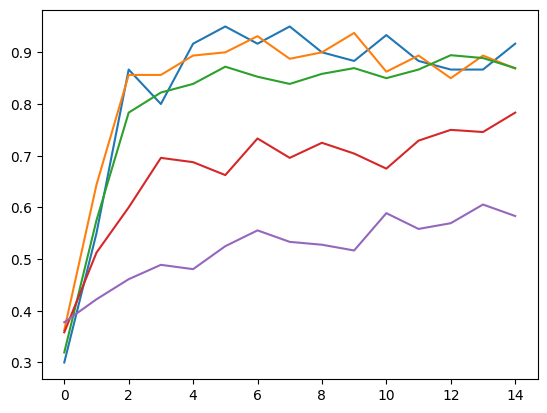

In [265]:
z = PR_data.groupby(['stim_ctr', 'set_size']).mean().reset_index()
plt.plot(z[z['set_size'] == 1]['corr'].values)
plt.plot(z[z['set_size'] == 2]['corr'].values)
plt.plot(z[z['set_size'] == 3]['corr'].values)
plt.plot(z[z['set_size'] == 4]['corr'].values)
plt.plot(z[z['set_size'] == 6]['corr'].values)

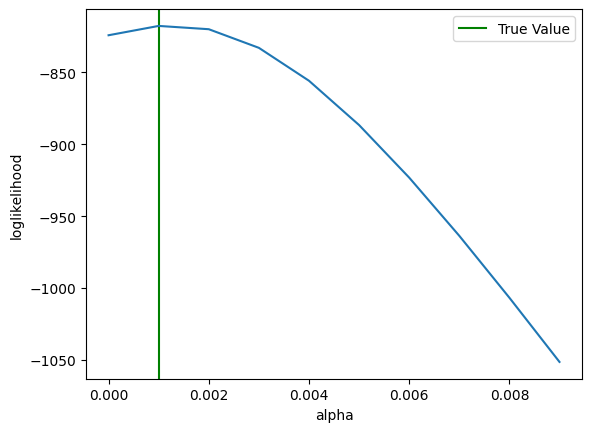

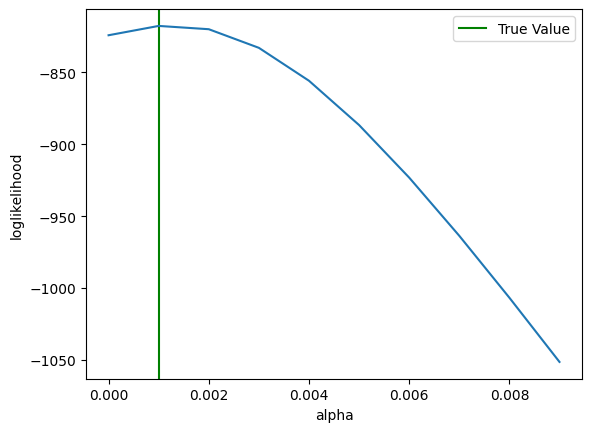

In [266]:
n_steps = 10
lower = 0
upper = 0.01
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
#ll1 = np.zeros((n_steps,))
#ll2 = np.zeros((n_steps,))
pA_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((1.0*step, pP_[0], pR_[0], pG_[0], pE_[0]), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, 3, pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_temp*step, pB_, pC_, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_).sum()

plt.xlabel('alpha')
plt.ylabel('loglikelihood')
plt.axvline(x=0.001, color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('alpha')
plt.ylabel('loglikelihood')
plt.axvline(x=0.001, color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

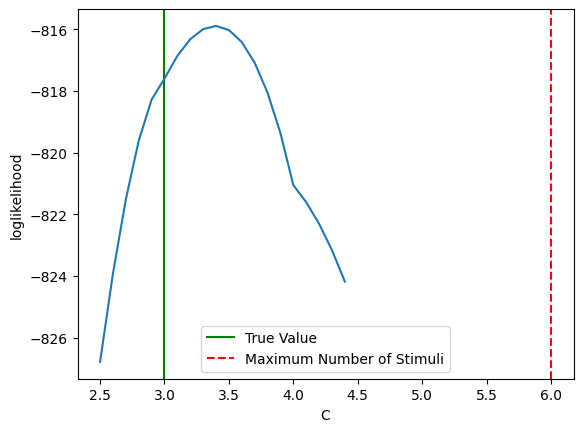

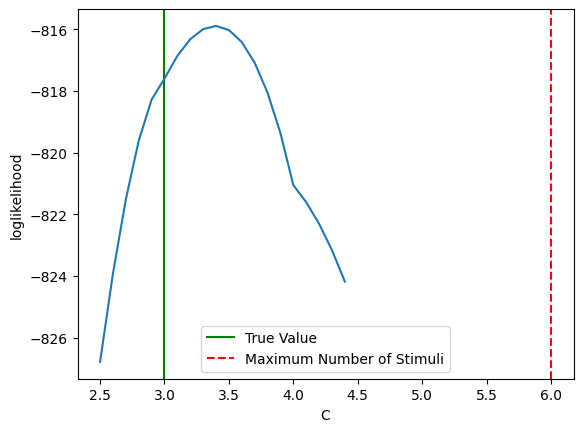

In [267]:
n_steps = 20
lower = 2.5
upper = 4.5
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pC_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pA_[0], pP_[0], pR_[0], pG_[0], pE_[0]), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, pC_temp[0]*step, pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_, pB_, pC_temp*step, pE_, pG_, pP_, pR_, choices_, rewards_, set_sizes_).sum()
plt.xlabel('C')
plt.ylabel('loglikelihood')
plt.axvline(x=3, color='g', linestyle='-', label='True Value')
plt.axvline(x=6, color='r', linestyle='--', label='Maximum Number of Stimuli')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('C')
plt.ylabel('loglikelihood')
plt.axvline(x=3, color='g', linestyle='-', label='True Value')
plt.axvline(x=6, color='r', linestyle='--', label='Maximum Number of Stimuli')
plt.legend()
plt.plot(steps,python_ll)
plt.show()

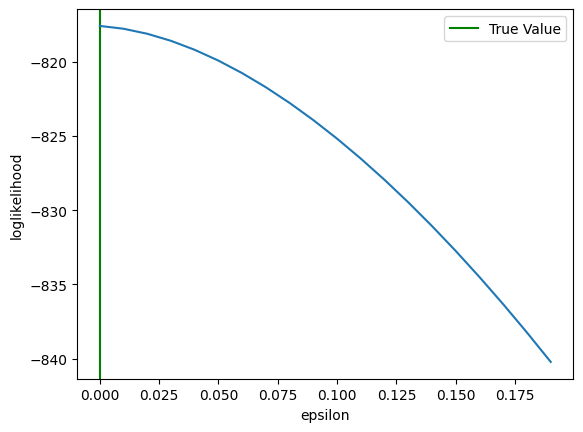

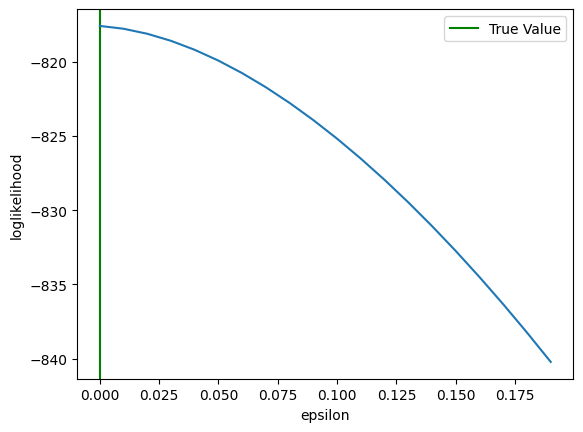

In [268]:
n_steps = 20
lower = 0
upper = 0.2
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
#ll1 = np.zeros((n_steps,))
#ll2 = np.zeros((n_steps,))
pE_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pA_[0], pP_[0], pR_[0], pG_[0], pE_temp[0]*step), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, pC_[0], pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_, pB_, pC_, pE_temp*step, pG_, pP_, pR_, choices_, rewards_, set_sizes_).sum()

plt.xlabel('epsilon')
plt.ylabel('loglikelihood')
plt.axvline(x=pE_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('epsilon')
plt.ylabel('loglikelihood')
plt.axvline(x=pE_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

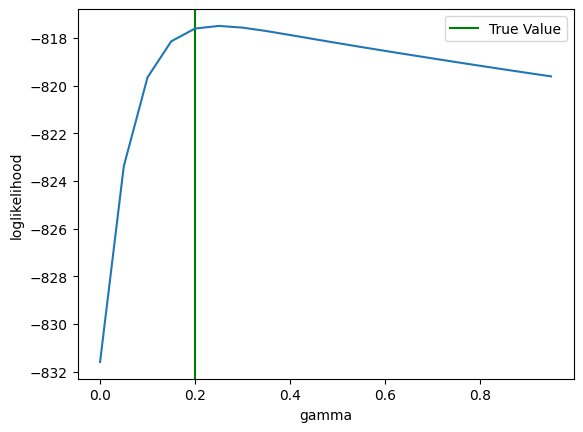

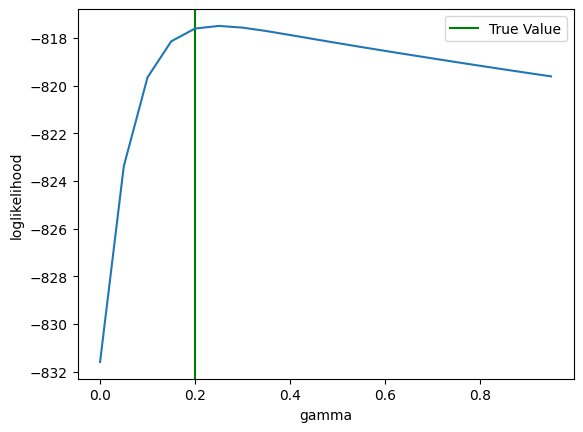

In [269]:
n_steps = 20
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pG_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pA_[0], pP_[0], pR_[0], pG_temp[0]*step, pE_[0]), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, pC_[0], pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_, pB_, pC_, pE_, pG_temp*step, pP_, pR_, choices_, rewards_, set_sizes_).sum()

plt.xlabel('gamma')
plt.ylabel('loglikelihood')
plt.axvline(x=pG_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('gamma')
plt.ylabel('loglikelihood')
plt.axvline(x=pG_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

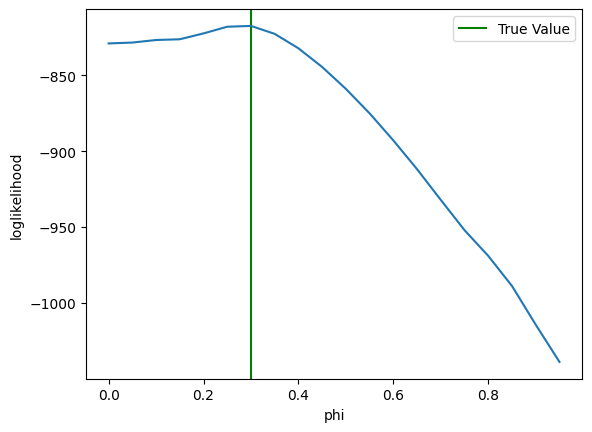

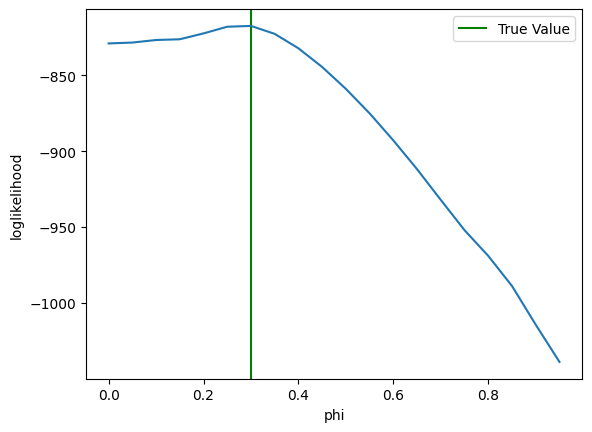

In [270]:
n_steps = 20
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
#ll1 = np.zeros((n_steps,))
#ll2 = np.zeros((n_steps,))
pP_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pA_[0], pP_temp[0]*step, pR_[0], pG_[0], pE_[0]), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, pC_[0], pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_temp*step, pR_, choices_, rewards_, set_sizes_).sum()

plt.xlabel('phi')
plt.ylabel('loglikelihood')
plt.axvline(x=pP_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('phi')
plt.ylabel('loglikelihood')
plt.axvline(x=pP_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

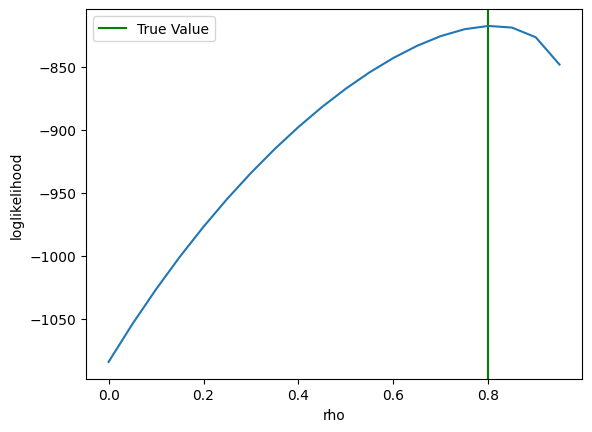

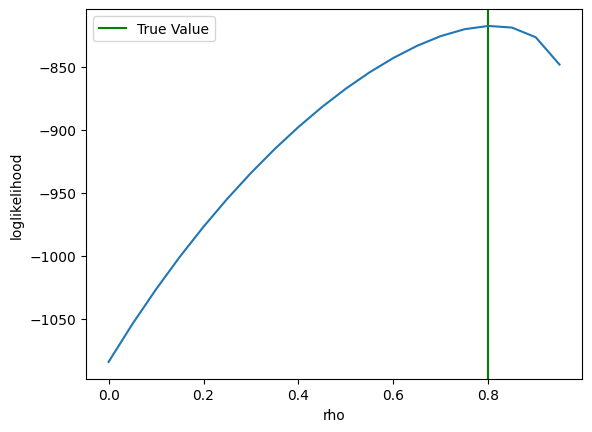

In [271]:
n_steps = 20
lower = 0
upper = 1.0
steps = np.arange(lower,upper,(upper-lower)/n_steps)
pytensor_ll = np.zeros((n_steps,))
python_ll = np.zeros((n_steps,))
pR_temp = np.ones(padded_ohe_df.shape[0]).flatten() * 1.0
for i, step in enumerate(steps):
    for subj_idx in df['subj_idx'].unique():
        python_ll[i] += RLWM_LL((pA_[0], pP_[0], pR_temp[0]*step, pG_[0], pE_[0]), PR_data.loc[PR_data['subj_idx']==subj_idx], 3, pC_[0], pB_[0])
    pytensor_ll[i] = my_rlwm_hdll_func(pA_, pB_, pC_, pE_, pG_, pP_, pR_temp*step, choices_, rewards_, set_sizes_).sum()

plt.xlabel('rho')
plt.ylabel('loglikelihood')
plt.axvline(x=pR_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,pytensor_ll)
plt.show()
plt.xlabel('rho')
plt.ylabel('loglikelihood')
plt.axvline(x=pR_[0], color='g', linestyle='-', label='True Value')
plt.legend()
plt.plot(steps,python_ll)

###Run PyMC

In [ ]:
# Make coordinates
participant_ids, participants = pd.factorize(padded_ohe_df['subj_idx'])
coords = {
          "participant_idx": np.array(participants),
          "obs_idx": np.arange(padded_ohe_df.shape[0])
         }

with pm.Model(coords=coords) as hierarchical_model:
    # Data
    #Choices = pm.ConstantData('Choices', padded_ohe_df['response'].to_numpy())
    #Rewards = pm.ConstantData('Rewards', padded_ohe_df['feedback'].to_numpy())
    #Set_sizes = pm.ConstantData('Set_sizes', padded_ohe_df['set_size'].to_numpy())
    Choices = pm.ConstantData('Choices', choices_)
    Rewards = pm.ConstantData('Rewards', rewards_)
    Set_sizes = pm.ConstantData('Set_sizes', set_sizes_)



    # Hyperpriors for group nodes
    # pA_alpha = 3 # pm.Gamma("pA_alpha", alpha = 3. , beta = 3.)
    # pA_beta = 3 # pm.Gamma("pA_beta", alpha = 3. , beta = 3.)
    # # pB_alpha = 3 # pm.Gamma("pB_alpha", alpha = 3. , beta = 3.)
    # # pB_beta = 3 # pm.Gamma("pB_beta", alpha = 3. , beta = 3.)
    # pC_alpha = 3 # pm.Gamma("pC_alpha", alpha = 3. , beta = 3.)
    # pC_beta = 3 # pm.Gamma("pC_beta", alpha = 3. , beta = 3.)
    # pE_alpha = 3 # pm.Gamma("pE_alpha", alpha = 3. , beta = 3.)
    # pE_beta = 3 # pm.Gamma("pE_beta", alpha = 3. , beta = 3.)
    # pG_alpha = 3 # pm.Gamma("pG_alpha", alpha = 3. , beta = 3.)
    # pG_beta = 3 # pm.Gamma("pG_beta", alpha = 3. , beta = 3.)
    # pP_alpha = 3 # pm.Gamma("pP_alpha", alpha = 3. , beta = 3.)
    # pP_beta = 3 # pm.Gamma("pP_beta", alpha = 3. , beta = 3.)
    # pR_alpha = 3 # pm.Gamma("pR_alpha", alpha = 3. , beta = 3.)
    # pR_beta = 3 # pm.Gamma("pR_beta", alpha = 3. , beta = 3.)

    # priors_rl_alpha = [0,0.01] # [0, 0.01]
    # priors_rl_phi = [0.30,0.30]# [0, 0.40]
    # priors_rl_rho = [0.8,0.8] # [0.75, 1]
    # priors_rl_gamma =[0.7,0.7] # [0.60, 0.90]
    # priors_rl_epsilon = [0.01,0.01] # [0, 0.05]
    # priors_rl_C = [3,3] # [2, 5]


    # Priors for variables
    # pA = pm.ConstantData('pA', np.ones_like(choices_) * rl_alpha[0])
    pB = pm.ConstantData('pB', np.ones_like(choices_) * 100.0)
    # pC = pm.ConstantData('pC', np.ones_like(choices_) * rl_C[0])
    # pE = pm.ConstantData('pE', np.ones_like(choices_) * rl_epsilon[0])
    # pG = pm.ConstantData('pG', np.ones_like(choices) * rl_gamma[0])
    # pP = pm.ConstantData('pP', np.ones_like(choices_) * rl_phi[0])
    # pR = pm.ConstantData('pR', np.ones_like(choices_) * rl_rho[0])
    pA = pm.Uniform(name='pA', lower=0.0, upper=0.2, dims="participant_idx")
    # pB = pm.Uniform(name="pB", lower=0.8, upper=1.2, dims="participant_idx")
    pC = pm.Uniform(name="pC", lower=1.0, upper=5.0, dims="participant_idx")
    pE = pm.Uniform(name="pE", lower=0, upper=0.5, dims="participant_idx")
    pG = pm.Uniform(name="pG", lower=0.0, upper=1.0, dims="participant_idx")
    pP = pm.Uniform(name="pP", lower=0.0, upper=1.0, dims="participant_idx")
    pR = pm.Uniform(name="pR", lower=0.0, upper=1.0, dims="participant_idx")
    # pA = pm.Beta(name="pA", alpha=pA_alpha, beta=pA_beta, dims="participant_idx")
    # pB = pm.Beta(name="pB", alpha=pB_alpha, beta=pB_beta, dims="participant_idx")
    # pC = pm.Beta(name="pC", alpha=pC_alpha, beta=pC_beta, dims="participant_idx")
    # pE = pm.Beta(name="pE", alpha=pE_alpha, beta=pE_beta, dims="participant_idx")
    # pG = pm.Beta(name="pG", alpha=pG_alpha, beta=pG_beta, dims="participant_idx")
    # pP = pm.Beta(name="pP", alpha=pP_alpha, beta=pP_beta, dims="participant_idx")
    # pR = pm.Beta(name="pR", alpha=pR_alpha, beta=pR_beta, dims="participant_idx")


    # Render parameters trial wise
    pA_trial = pA[participant_ids]
    # pB_trial = pB[participant_ids]
    pC_trial = pC[participant_ids]
    pE_trial = pE[participant_ids]
    pG_trial = pG[participant_ids]
    pP_trial = pP[participant_ids]
    pR_trial = pR[participant_ids]
    # pA_trial = pA
    pB_trial = pB
    #pC_trial = pC
    #pE_trial = pE
    # pG_trial = pG
    #pP_trial = pP
    #pR_trial = pR

    # CHOOSE WHICH WRAPPER FUNCTION TO USE HERE
    pm.Potential("likelihood", rlwm_hdll(pA_trial,pB_trial,pC_trial,pE_trial,pG_trial,pP_trial,pR_trial,Choices,Rewards,Set_sizes))
    idata_pooled = pm.sample(1000, tune=1000, chains=2, nuts_sampler="numpyro")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
az.plot_pair(idata_pooled)

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'pA', 'pE', 'pR', 'pC', 'pP'} expected from {'pG'}
  warnings.warn(


array([[<Axes: title={'center': 'pG'}>, <Axes: title={'center': 'pG'}>]],
      dtype=object)

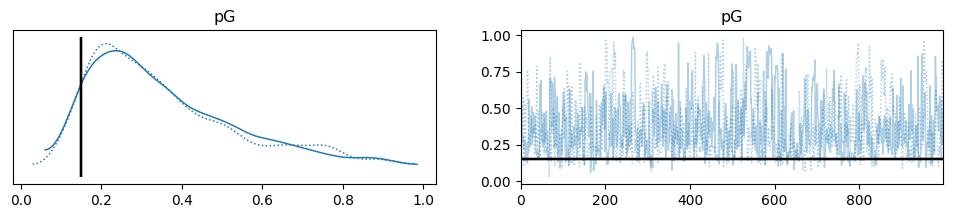

In [137]:
az.plot_trace(idata_pooled, lines=[
    ("pA", {}, rl_alpha),
    ("pC", {}, rl_C),
    ("pE", {}, rl_epsilon),
    ("pG", {}, rl_gamma),
    ("pP", {}, rl_phi),
    ("pR", {}, rl_rho),
])

In [ ]:
az.plot_forest(idata_pooled, ref_val={'alpha':0.5})

TypeError: plot_forest() got an unexpected keyword argument 'ref_val'